# QuantConnect (Lean) Backtesting Demo

This notebook demonstrates how to run backtests using **QuantConnect Lean**, a professional-grade open-source backtesting engine.

## What This Notebook Does

1. **Locates the strategy code** - Shows where the Python algorithm is stored
2. **Runs the Lean backtest engine** - Executes the strategy against historical data
3. **Loads backtest results** - Extracts performance statistics and equity curves
4. **Visualizes results** - Plots equity curve and drawdown charts

## Workflow Overview

```
Strategy Code (Python) → Lean Engine → Results JSON → Visualization
```

**Outputs (after running):**
- `qc_lean/Results/MomentumDemoAlgorithm-summary.json` - Key statistics
- `qc_lean/Results/MomentumDemoAlgorithm.json` - Full detailed results
- Charts inline in this notebook


## Step 1: Setup Paths and Check Environment

First, we set up the paths to the Lean engine executable and results directory. This cell also checks if previous results exist.


In [4]:
from __future__ import annotations

import json
import logging
import os
import subprocess
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Setup logging with timestamps
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

REPO_ROOT = Path("/Users/zelin/Desktop/PA Investment/Invest_strategy")
LEAN_BIN = REPO_ROOT / "qc_lean" / "Lean" / "Launcher" / "bin" / "Release"
RESULTS_DIR = REPO_ROOT / "qc_lean" / "Results"
SUMMARY_JSON = RESULTS_DIR / "MomentumDemoAlgorithm-summary.json"
FULL_JSON = RESULTS_DIR / "MomentumDemoAlgorithm.json"

logger.info("=" * 80)
logger.info("BACKTEST SETUP")
logger.info("=" * 80)
logger.info(f"Repository root: {REPO_ROOT}")
logger.info(f"Lean binary directory: {LEAN_BIN}")
logger.info(f"Results directory: {RESULTS_DIR}")
logger.info(f"Summary JSON exists: {SUMMARY_JSON.exists()}")
logger.info(f"Full JSON exists: {FULL_JSON.exists()}")

print("LEAN_BIN:", LEAN_BIN)
print("RESULTS_DIR:", RESULTS_DIR)
print("summary exists?", SUMMARY_JSON.exists())


2026-01-13 00:09:35 - INFO - ================================================================================
2026-01-13 00:09:35 - INFO - BACKTEST SETUP
2026-01-13 00:09:35 - INFO - ================================================================================
2026-01-13 00:09:35 - INFO - Repository root: /Users/zelin/Desktop/PA Investment/Invest_strategy
2026-01-13 00:09:35 - INFO - Lean binary directory: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Launcher/bin/Release
2026-01-13 00:09:35 - INFO - Results directory: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Results
2026-01-13 00:09:35 - INFO - Summary JSON exists: True
2026-01-13 00:09:35 - INFO - Full JSON exists: True


LEAN_BIN: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Launcher/bin/Release
RESULTS_DIR: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Results
summary exists? True


## Step 1.5: Extract Market Data (Optional)

**How to get market data for backtesting:**

The current demo uses Lean's built-in sample data. To use your own data, you can extract market data from free sources like Stooq.

**Data extraction code location:**
- `quant_data/connectors/stooq.py` - Connector that downloads data from Stooq (free daily OHLCV)
- `scripts/qc_build_equity_daily.py` - Script to format data for Lean

**Example: Extract SPY data from Stooq**

In [ ]:
# Example: Extract market data using the Stooq connector
# This shows how to download historical market data for use in backtests

import sys
from pathlib import Path

# Add project root to path to import quant_data modules
sys.path.insert(0, str(REPO_ROOT))

from quant_data.connectors.base import BarsRequest
from quant_data.connectors.stooq import StooqBarsConnector

logger.info("=" * 80)
logger.info("MARKET DATA EXTRACTION EXAMPLE")
logger.info("=" * 80)

# Initialize the Stooq connector (free daily bars)
connector = StooqBarsConnector()
logger.info("✓ Stooq connector initialized")

# Example: Fetch SPY data for a date range
symbol = "SPY"
start_date = "2013-01-01"
end_date = "2013-12-31"

logger.info(f"Fetching {symbol} data from {start_date} to {end_date}...")

request = BarsRequest(
    symbols=[symbol],
    start=start_date,
    end=end_date,
    venue="STOOQ",
    currency="USD"
)

# Extract the data
df = connector.fetch_bars(request)

if not df.empty:
    logger.info(f"✓ Successfully extracted {len(df)} bars")
    logger.info(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    logger.info(f"  Columns: {list(df.columns)}")
    
    # Display sample data
    print(f"\nExtracted {len(df)} bars for {symbol}")
    print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nLast 5 rows:")
    print(df.tail())
    
    # Show basic statistics
    print("\nPrice Statistics:")
    print(df[['open', 'high', 'low', 'close', 'volume']].describe())
else:
    logger.warning(f"No data returned for {symbol}")
    print(f"No data found for {symbol} in the specified date range")

# Note: To use this data in Lean, you would need to:
# 1. Run: python scripts/qc_build_equity_daily.py --out qc_lean/Lean/Data --symbol SPY --start 2013-01-01 --end 2013-12-31
# 2. This creates the required files in Lean's data format

### How Market Data Extraction Works

**The extraction code is in `quant_data/connectors/stooq.py`:**

The key method is `fetch_bars()`, which:
1. **Downloads CSV from Stooq's public API**: `https://stooq.com/q/d/l/?s={symbol}&i=d`
2. **Renames columns** to match our canonical format (timestamp, open, high, low, close, volume)
3. **Filters by date range** (start to end, inclusive)
4. **Returns a pandas DataFrame** with standardized columns

**Key code snippet:**
```python
# Line 40-41 in stooq.py
url = f"https://stooq.com/q/d/l/?s={stooq_sym}&i=d"
df = pd.read_csv(url)  # Downloads CSV directly from Stooq
```

**To use extracted data in Lean:**
1. Extract data using the connector (as shown above)
2. Run `scripts/qc_build_equity_daily.py` to format it for Lean
3. The script creates:
   - `Data/equity/usa/daily/{symbol}.zip` - Daily bars in Lean format
   - `Data/equity/usa/map_files/{symbol}.csv` - Symbol mapping
   - `Data/equity/usa/factor_files/{symbol}.csv` - Price adjustments

In [ ]:
# Display the market data extraction code
EXTRACTION_CODE_FILE = REPO_ROOT / "quant_data" / "connectors" / "stooq.py"

logger.info("=" * 80)
logger.info("MARKET DATA EXTRACTION CODE")
logger.info("=" * 80)
logger.info(f"File location: {EXTRACTION_CODE_FILE}")
logger.info(f"File exists: {EXTRACTION_CODE_FILE.exists()}")

if EXTRACTION_CODE_FILE.exists():
    with open(EXTRACTION_CODE_FILE, "r") as f:
        code = f.read()
        logger.info(f"Code loaded ({len(code)} characters)")
        
        print(f"Extraction code location: {EXTRACTION_CODE_FILE}\n")
        print("=" * 80)
        print("MARKET DATA EXTRACTION CODE (stooq.py):")
        print("=" * 80)
        print(code)
else:
    logger.error(f"Extraction code file not found at {EXTRACTION_CODE_FILE}")
    print(f"ERROR: File not found at {EXTRACTION_CODE_FILE}")

## Step 2: Locate and View the Strategy Code

**Where is the strategy?** The strategy is a Python class that inherits from `QCAlgorithm`. It's located at:

`qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py`

### How to Create/Modify a Strategy

1. **Edit the existing strategy**: Open `qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py` and modify the `Initialize()` and `OnData()` methods.

2. **Create a new strategy**: 
   - Create a new `.py` file in `qc_lean/Lean/Algorithm.Python/`
   - Inherit from `QCAlgorithm`
   - Update `qc_lean/config.json` to point to your new algorithm file

3. **Strategy structure**:
   - `Initialize()`: Set up dates, cash, symbols, indicators
   - `OnData()`: Called on each market data update - implement your trading logic here

Let's view the current strategy code:


In [5]:
# Display the strategy code
STRATEGY_FILE = REPO_ROOT / "qc_lean" / "Lean" / "Algorithm.Python" / "MomentumDemoAlgorithm.py"

logger.info("=" * 80)
logger.info("STRATEGY CODE LOCATION")
logger.info("=" * 80)
logger.info(f"Strategy file: {STRATEGY_FILE}")
logger.info(f"File exists: {STRATEGY_FILE.exists()}")

print(f"Strategy location: {STRATEGY_FILE}")
print(f"File exists: {STRATEGY_FILE.exists()}\n")
print("=" * 80)
print("STRATEGY CODE:")
print("=" * 80)

if STRATEGY_FILE.exists():
    with open(STRATEGY_FILE, "r") as f:
        code = f.read()
        logger.info(f"Strategy code loaded ({len(code)} characters)")
        print(code)
else:
    logger.error(f"Strategy file not found at {STRATEGY_FILE}")
    print(f"ERROR: Strategy file not found at {STRATEGY_FILE}")


2026-01-13 00:09:35 - INFO - ================================================================================
2026-01-13 00:09:35 - INFO - STRATEGY CODE LOCATION
2026-01-13 00:09:35 - INFO - ================================================================================
2026-01-13 00:09:35 - INFO - Strategy file: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py
2026-01-13 00:09:35 - INFO - File exists: True
2026-01-13 00:09:35 - INFO - Strategy code loaded (1326 characters)


Strategy location: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py
File exists: True

STRATEGY CODE:
from AlgorithmImports import *


class MomentumDemoAlgorithm(QCAlgorithm):
    """
    Dummy momentum strategy (minute):
    - Trade SPY only
    - Compute 60-minute ROC
    - If ROC > 0: long SPY
    - Else: stay in cash
    """

    def Initialize(self):
        # Use the built-in sample dataset shipped with Lean (SPY minute data for a short window)
        self.SetStartDate(2013, 10, 7)
        self.SetEndDate(2013, 10, 11)
        self.SetCash(100000)

        self.symbol = self.AddEquity("SPY", Resolution.Minute).Symbol

        # 60-minute momentum (ROC over last 60 minute bars)
        self.roc = self.ROC(self.symbol, 60, Resolution.Minute)

        # No warmup: ROC becomes ready after ~60 minutes of data

        # Charting
        self.PlotIndicator("Indicators", self.roc)
        self.current_state = None

    def OnDat

### Strategy Explanation

**What this strategy does:**
- **Symbol**: Trades SPY (S&P 500 ETF) on minute bars
- **Indicator**: 60-minute Rate of Change (ROC) - measures price momentum over the last 60 minutes
- **Logic**: 
  - If ROC > 0 (positive momentum): Go 100% long SPY
  - If ROC ≤ 0 (negative/zero momentum): Stay in cash (0% position)
- **Period**: October 7-11, 2013 (uses Lean's built-in sample data)

**Key Lean concepts:**
- `SetStartDate()` / `SetEndDate()`: Define backtest period
- `AddEquity()`: Subscribe to equity data at a specific resolution (Minute, Hour, Daily)
- `ROC()`: Built-in indicator for Rate of Change
- `OnData()`: Called whenever new market data arrives
- `SetHoldings()`: Set target portfolio allocation (1.0 = 100% long, 0.0 = cash)


## Step 3: Run the Lean Backtest Engine

**How backtesting works:**

1. Lean reads the strategy from `MomentumDemoAlgorithm.py`
2. It loads historical market data (SPY minute bars for Oct 7-11, 2013)
3. It simulates running the strategy day-by-day, calling `OnData()` for each minute bar
4. It tracks orders, fills, portfolio value, and calculates performance metrics
5. It writes results to JSON files in `qc_lean/Results/`

**Environment variables needed:**
- `DOTNET_ROOT`: Path to .NET SDK (required to run Lean)
- `PYTHONNET_PYDLL`: Path to Python shared library (for Python algorithms)
- `PYTHONHOME`: Python installation path

**Note**: Lean may exit with a pythonnet shutdown error on some systems, but it still writes valid results JSON before exiting.


In [6]:
# Run the Lean backtest (MomentumDemoAlgorithm)
# Note: Lean exits with a pythonnet shutdown error on this machine, but it *still writes results JSON*.

logger.info("=" * 80)
logger.info("STARTING BACKTEST EXECUTION")
logger.info("=" * 80)

start_time = datetime.now()
logger.info(f"Backtest start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Setup environment
DOTNET_ROOT = str(REPO_ROOT / "qc_lean" / ".dotnet")
PYTHONNET_PYDLL = "/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/lib/libpython3.11.dylib"
PYTHONHOME = "/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11"

logger.info("Configuring environment variables...")
logger.info(f"  DOTNET_ROOT: {DOTNET_ROOT}")
logger.info(f"  PYTHONNET_PYDLL: {PYTHONNET_PYDLL}")
logger.info(f"  PYTHONHOME: {PYTHONHOME}")

env = os.environ.copy()
env["DOTNET_ROOT"] = DOTNET_ROOT
env["PATH"] = DOTNET_ROOT + os.pathsep + env.get("PATH", "")
env["PYTHONNET_PYDLL"] = PYTHONNET_PYDLL
env["PYTHONHOME"] = PYTHONHOME

# Check if Lean executable exists
lean_exe = LEAN_BIN / "QuantConnect.Lean.Launcher"
if not lean_exe.exists():
    logger.error(f"Lean executable not found at {lean_exe}")
    raise FileNotFoundError(f"Lean executable not found at {lean_exe}")

logger.info(f"Lean executable found: {lean_exe}")
logger.info(f"Working directory: {LEAN_BIN}")

cmd = ["./QuantConnect.Lean.Launcher"]
logger.info(f"Executing command: {' '.join(cmd)}")
logger.info("Backtest is running... (this may take a few minutes)")

print("Running:", " ".join(cmd))
print("Backtest started at:", start_time.strftime('%Y-%m-%d %H:%M:%S'))

try:
    proc = subprocess.run(
        cmd,
        cwd=str(LEAN_BIN),
        env=env,
        text=True,
        capture_output=True,
        timeout=300,
    )
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    logger.info("=" * 80)
    logger.info("BACKTEST EXECUTION COMPLETED")
    logger.info("=" * 80)
    logger.info(f"Backtest end time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    logger.info(f"Total duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    logger.info(f"Exit code: {proc.returncode}")
    
    # Log output summary
    stdout_lines = proc.stdout.splitlines()
    stderr_lines = proc.stderr.splitlines()
    logger.info(f"Stdout lines: {len(stdout_lines)}")
    logger.info(f"Stderr lines: {len(stderr_lines)}")
    
    # Check for key indicators in output
    if "Processing total of" in proc.stdout:
        for line in stdout_lines:
            if "Processing total of" in line:
                logger.info(f"Data processing: {line.strip()}")
    
    if "Algorithm finished" in proc.stdout or "Algorithm completed" in proc.stdout:
        logger.info("Algorithm completed successfully")
    
    print(f"\nBacktest completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Duration: {duration:.2f} seconds")
    print("exit_code:", proc.returncode)
    print("--- stdout tail ---")
    print("\n".join(stdout_lines[-40:]))
    print("--- stderr tail ---")
    print("\n".join(stderr_lines[-40:]))
    
except subprocess.TimeoutExpired:
    logger.error("Backtest execution timed out after 300 seconds")
    raise
except Exception as e:
    logger.error(f"Error during backtest execution: {e}")
    raise

# Check results
logger.info("=" * 80)
logger.info("CHECKING BACKTEST RESULTS")
logger.info("=" * 80)

summary_exists = SUMMARY_JSON.exists()
full_exists = FULL_JSON.exists()

logger.info(f"Summary JSON exists: {summary_exists} ({SUMMARY_JSON})")
logger.info(f"Full JSON exists: {full_exists} ({FULL_JSON})")

if summary_exists:
    file_size = SUMMARY_JSON.stat().st_size
    logger.info(f"Summary JSON size: {file_size:,} bytes")
    
if full_exists:
    file_size = FULL_JSON.stat().st_size
    logger.info(f"Full JSON size: {file_size:,} bytes")

if summary_exists and full_exists:
    logger.info("✓ Backtest results successfully generated!")
else:
    logger.warning("⚠ Some result files are missing. Check Lean output above for errors.")

print("\nWrote:")
print("-", SUMMARY_JSON, "exists?", summary_exists)
print("-", FULL_JSON, "exists?", full_exists)


2026-01-13 00:09:35 - INFO - ================================================================================
2026-01-13 00:09:35 - INFO - STARTING BACKTEST EXECUTION
2026-01-13 00:09:35 - INFO - ================================================================================


2026-01-13 00:09:35 - INFO - Backtest start time: 2026-01-13 00:09:35
2026-01-13 00:09:35 - INFO - Configuring environment variables...
2026-01-13 00:09:35 - INFO -   DOTNET_ROOT: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/.dotnet
2026-01-13 00:09:35 - INFO -   PYTHONNET_PYDLL: /opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/lib/libpython3.11.dylib
2026-01-13 00:09:35 - INFO -   PYTHONHOME: /opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11
2026-01-13 00:09:35 - INFO - Lean executable found: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Launcher/bin/Release/QuantConnect.Lean.Launcher
2026-01-13 00:09:35 - INFO - Working directory: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Lean/Launcher/bin/Release
2026-01-13 00:09:35 - INFO - Executing command: ./QuantConnect.Lean.Launcher
2026-01-13 00:09:35 - INFO - Backtest is running... (this may take a few minutes)


Running: ./QuantConnect.Lean.Launcher
Backtest started at: 2026-01-13 00:09:35


2026-01-13 00:14:35 - ERROR - Backtest execution timed out after 300 seconds


: 

## Step 4: Load and Display Backtest Statistics

After the backtest completes, Lean writes a summary JSON with key performance metrics. This cell extracts and displays:

- **Net Profit**: Total profit/loss in dollars
- **End Equity**: Final portfolio value
- **Drawdown**: Maximum peak-to-trough decline
- **Sharpe Ratio**: Risk-adjusted return metric
- **Total Fees**: Transaction costs incurred
- **Total Orders**: Number of orders executed
- **Portfolio Turnover**: How frequently positions changed


In [7]:
# Load stats from the Lean summary JSON

logger.info("=" * 80)
logger.info("LOADING BACKTEST RESULTS")
logger.info("=" * 80)

if not SUMMARY_JSON.exists():
    logger.error(f"Summary JSON not found at {SUMMARY_JSON}")
    raise FileNotFoundError(f"Summary JSON not found at {SUMMARY_JSON}")

logger.info(f"Loading summary from: {SUMMARY_JSON}")

try:
    results = json.loads(SUMMARY_JSON.read_text(encoding="utf-8"))
    logger.info("✓ Summary JSON loaded successfully")
    
    stats = results.get("statistics", {})
    logger.info(f"Found {len(stats)} statistics")
    
    # Extract key metrics
    key_stats = {
        "Net Profit": stats.get("Net Profit"),
        "End Equity": stats.get("End Equity"),
        "Drawdown": stats.get("Drawdown"),
        "Sharpe": stats.get("Sharpe Ratio"),
        "Total Fees": stats.get("Total Fees"),
        "Total Orders": stats.get("Total Orders"),
        "Portfolio Turnover": stats.get("Portfolio Turnover"),
    }
    
    # Log key metrics
    logger.info("Key Performance Metrics:")
    for key, value in key_stats.items():
        if value is not None:
            logger.info(f"  {key}: {value}")
    
    # Display as DataFrame
    stats_df = pd.Series(key_stats).to_frame("value")
    logger.info("✓ Statistics extracted and formatted")
    
    print("\nBacktest Statistics:")
    print(stats_df)
    
    stats_df
    
except json.JSONDecodeError as e:
    logger.error(f"Failed to parse JSON: {e}")
    raise
except Exception as e:
    logger.error(f"Error loading results: {e}")
    raise


2026-01-13 00:15:39 - INFO - ================================================================================
2026-01-13 00:15:39 - INFO - LOADING BACKTEST RESULTS
2026-01-13 00:15:39 - INFO - ================================================================================
2026-01-13 00:15:39 - INFO - Loading summary from: /Users/zelin/Desktop/PA Investment/Invest_strategy/qc_lean/Results/MomentumDemoAlgorithm-summary.json
2026-01-13 00:15:39 - INFO - ✓ Summary JSON loaded successfully
2026-01-13 00:15:39 - INFO - Found 27 statistics
2026-01-13 00:15:39 - INFO - Key Performance Metrics:
2026-01-13 00:15:39 - INFO -   Net Profit: -0.885%
2026-01-13 00:15:39 - INFO -   End Equity: 99114.74
2026-01-13 00:15:39 - INFO -   Drawdown: 1.800%
2026-01-13 00:15:39 - INFO -   Sharpe: -2.846
2026-01-13 00:15:39 - INFO -   Total Fees: $432.60
2026-01-13 00:15:39 - INFO -   Total Orders: 127
2026-01-13 00:15:39 - INFO -   Portfolio Turnover: 2531.59%
2026-01-13 00:15:39 - INFO - ✓ Statistics extract


Backtest Statistics:
                       value
Net Profit           -0.885%
End Equity          99114.74
Drawdown              1.800%
Sharpe                -2.846
Total Fees           $432.60
Total Orders             127
Portfolio Turnover  2531.59%


## Step 5: Visualize Results

The full results JSON contains time-series data for equity curves, drawdowns, and other metrics. This cell:

1. Extracts the "Strategy Equity" series from the results
2. Calculates drawdown (current equity vs. peak equity)
3. Plots both as time series charts

**Equity Curve**: Shows how portfolio value changes over time
**Drawdown**: Shows periods of losses relative to the previous peak


2026-01-13 00:15:50 - INFO - ================================================================================
2026-01-13 00:15:50 - INFO - GENERATING VISUALIZATIONS
2026-01-13 00:15:50 - INFO - ================================================================================
2026-01-13 00:15:50 - INFO - Extracting equity curve from results...
2026-01-13 00:15:50 - INFO - ✓ Equity curve extracted: 2 data points
2026-01-13 00:15:50 - INFO -   Date range: 2013-10-07 04:00:00+00:00 to 2013-10-10 04:00:00+00:00
2026-01-13 00:15:50 - INFO -   Initial equity: $100,000.00
2026-01-13 00:15:50 - INFO -   Final equity: $98,372.34
2026-01-13 00:15:50 - INFO - Calculating drawdown...
2026-01-13 00:15:50 - INFO - ✓ Drawdown calculated. Maximum drawdown: -1.63%
2026-01-13 00:15:50 - INFO - Creating plots...
2026-01-13 00:15:50 - INFO - ✓ Visualizations generated successfully


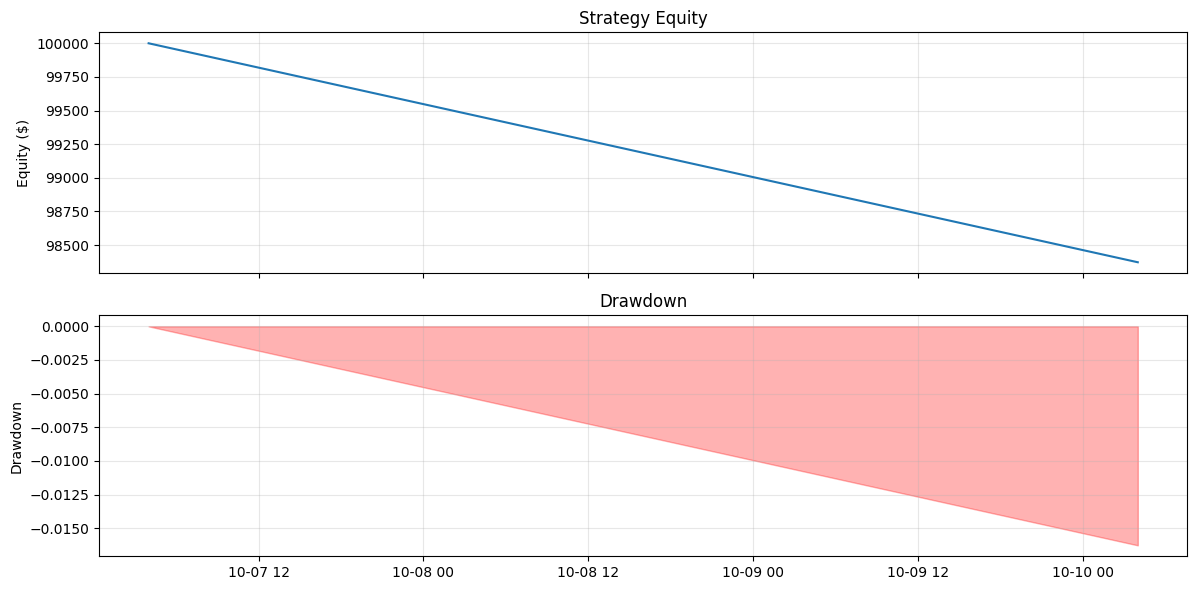

In [8]:
# Plot equity + drawdown (from charts in JSON)

logger.info("=" * 80)
logger.info("GENERATING VISUALIZATIONS")
logger.info("=" * 80)

def extract_series(results: dict, chart_name: str, series_name: str) -> pd.DataFrame:
    """Extract a time series from Lean results JSON."""
    charts = results.get("charts") or {}
    chart = charts.get(chart_name) or {}
    series = (chart.get("series") or {}).get(series_name) or {}
    values = series.get("values") or []
    if not values:
        return pd.DataFrame()

    rows = []
    for v in values:
        ts = pd.to_datetime(int(v[0]), unit="s", utc=True)
        # Equity curve is often OHLC-like: [ts, open, high, low, close]
        y = float(v[4]) if len(v) >= 5 else float(v[1])
        rows.append({"timestamp": ts, "value": y})

    return pd.DataFrame(rows).set_index("timestamp").sort_index()

logger.info("Extracting equity curve from results...")
equity = extract_series(results, "Strategy Equity", "Equity")

if equity.empty:
    logger.error("Could not find Strategy Equity/Equity series in results")
    raise RuntimeError("Could not find Strategy Equity/Equity series")

logger.info(f"✓ Equity curve extracted: {len(equity)} data points")
logger.info(f"  Date range: {equity.index.min()} to {equity.index.max()}")
logger.info(f"  Initial equity: ${equity['value'].iloc[0]:,.2f}")
logger.info(f"  Final equity: ${equity['value'].iloc[-1]:,.2f}")

logger.info("Calculating drawdown...")
drawdown = equity["value"] / equity["value"].cummax() - 1.0
max_dd = drawdown.min()
logger.info(f"✓ Drawdown calculated. Maximum drawdown: {max_dd:.2%}")

logger.info("Creating plots...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Equity curve
ax1.plot(equity.index, equity["value"], linewidth=1.5)
ax1.set_title("Strategy Equity")
ax1.set_ylabel("Equity ($)")
ax1.grid(True, alpha=0.3)

# Drawdown
ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
ax2.set_title("Drawdown")
ax2.set_ylabel("Drawdown")
ax2.grid(True, alpha=0.3)

fig.tight_layout()
logger.info("✓ Visualizations generated successfully")
plt.show()


In [9]:
equity

,value
timestamp,
2013-10-07 04:00:00+00:00,100000.0000
2013-10-10 04:00:00+00:00,98372.3421


## How to Backtest Your Own Strategy

### Option 1: Modify the Existing Strategy

1. Edit `qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py`
2. Change the logic in `OnData()` or add new indicators in `Initialize()`
3. Re-run the cells above to see new results

### Option 2: Create a New Strategy File

1. Create a new file: `qc_lean/Lean/Algorithm.Python/MyStrategy.py`
2. Copy the template structure from `MomentumDemoAlgorithm.py`
3. Update `qc_lean/config.json`:
   ```json
   {
     "algorithm-type-name": "MyStrategy",
     "algorithm-language": "Python",
     "algorithm-location": "../../Algorithm.Python/MyStrategy.py"
   }
   ```
4. Update the notebook paths to look for `MyStrategy-summary.json` instead

### Option 3: Use Custom Data

To backtest with your own data:
1. Convert your data to Lean's format (see `scripts/qc_build_equity_daily.py` for an example)
2. Place data files in `qc_lean/Lean/Data/equity/usa/daily/`
3. Update the strategy's `SetStartDate()` / `SetEndDate()` to match your data range

### Key Lean Resources

- **Lean Documentation**: https://www.quantconnect.com/docs
- **Algorithm Examples**: https://github.com/QuantConnect/Lean/tree/master/Algorithm.Python
- **Indicators**: https://www.quantconnect.com/docs/algorithm-reference/indicators

## File Locations Summary

**Strategy Code:**
- `qc_lean/Lean/Algorithm.Python/MomentumDemoAlgorithm.py` - The Python algorithm

**Configuration:**
- `qc_lean/config.json` - Lean engine configuration (algorithm name, data paths)

**Results (generated after backtest):**
- `qc_lean/Results/MomentumDemoAlgorithm-summary.json` - Key statistics
- `qc_lean/Results/MomentumDemoAlgorithm.json` - Full detailed results with all time series

**Data:**
- `qc_lean/Lean/Data/` - Historical market data (SPY minute bars for this demo)
